<a href="https://colab.research.google.com/github/JorgeRR89/The-MovieLens-Dataset/blob/main/SoftImpute_for_Movielens_Mod8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project Overview

This project implements a collaborative filtering recommendation system using the MovieLens dataset and the SoftImpute matrix completion algorithm. The objective is to predict missing user–movie ratings by reconstructing an incomplete user–item matrix through low-rank approximation.

The workflow includes:

1. Loading MovieLens ratings and preparing a sparse user–movie matrix where missing values are set to `NaN`.
2. Remapping movie IDs to continuous indices since many movies in the database have no ratings.
3. Creating a training set (90% of observed ratings) and a validation set (10%).
4. Normalizing the matrix using BiScaler to stabilize numerical behavior.
5. Applying SoftImpute to estimate the missing entries through iterative low-rank updates.
6. Computing in-sample and out-of-sample R² to assess model quality.
7. Inspecting the learned latent factor matrices for users and movies.

This pipeline reproduces a simplified but realistic version of the algorithmic foundations behind modern recommender systems.



[texto del vínculo](https://)#  The MovieLens Dataset

[MovieLens](https://movielens.org/) is a non-commercial web-based movie recommender system, created in 1997 by GroupLens, a research lab at the University of Minnesota, in order to gather movie rating data for research purposes.


## Getting the Data


The MovieLens dataset is hosted by the [GroupLens](https://grouplens.org/datasets/movielens/) website. Several versions are available. We will use the latest smallest dataset released from [link](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip).

## Custom Code

The custom packages; soft_impute and functionsCF will need to be installed

In [1]:
# Install the standard papackages
!pip install numpy
!pip install pandas
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.6 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=46f873c9f579bda6a1dff4e45935091e19d9b46da7e4e38d5360f5ddc15d34b5
  Stored in directory: /root/.cache/pip/wheels/df/20/91/e4850b9a31cf660c1bc95515d3bcbc8010e869e5de6d5baf07
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11331 sha256=14cf8f0aa61d35716d560e7e93d81a9233a68d44f790172301794354689fb147
  Stored in directory: /root/.cache/pip/wheels/89/11/61/aa5a3167bfff49218cd043a73a83034b9eadd858b0059521be
Successfully built fancyimpute knnimpute


Google Collab Connection to Google Drive: External data: Local Files, Drive, Sheets, and Cloud Storage
https://colab.research.google.com/notebooks/io.ipynb

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# location of custom packages: soft_impute , functionsCF, and dataset ratings.csv
# CollaborativeFiltering folder in google drive
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CollaborativeFiltering/')

In [4]:
# change the working directory
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/CollaborativeFiltering/")

In [5]:
# Impute necessary packages
import numpy as np
import pandas as pd
from fancyimpute import BiScaler
from soft_impute import SoftImpute
from functionsCF import GenerateTrainingSet

## Create the incomplete matrices for training and testing

In [6]:
# Read movielens data from files- point to where data is stored, small set of Movielens dataset
# 100836 (rows), userId	movieId	rating	timestamp (columns).
# Using smaller dataset rather than the full dataset to speed performance.
# Your results may vary depending on which Movielens data set is used; Several are available online
# read in values only
rating = pd.read_csv('ratings.csv', sep=',').values

In [7]:
# Here we only care about the ratings, so we only use the first three columns, which contain use IDs, movie IDs, and ratings.
rating = rating[:,0:3]

In [8]:
#show top 5 rows
print(rating[:5, :])

[[ 1.  1.  4.]
 [ 1.  3.  4.]
 [ 1.  6.  4.]
 [ 1. 47.  5.]
 [ 1. 50.  5.]]


In [9]:
# Use all known information to create the incomplete matrix

# First, create an empty matrix
matrix_incomplete = np.zeros((len(np.unique(rating[:,0])), len(np.unique(rating[:,1]))))

# Second, Since some movies don't have any ratings, we only use the movies that have ratings.
# Here we correspondingly change the movie IDs to make each column has ratings.
# create an array of all movie IDs
usedID = np.unique(rating[:, 1])
# replace the movie IDs by the their positions in the array we just created
for i in range(len(rating[:,1])):
    rating[:,1][i] = np.where(usedID==rating[:,1][i])[0][0] + 1

# Finally, we construct the incomplete matrix, on which the incomplete components are nan by
# default.
# all components are nan by default
matrix_incomplete[:] = np.nan
# create the index pair of the components with ratings
indices = np.array(rating[:,0] - 1).astype(int), np.array(rating[:,1] - 1).astype(int)
# change the values in the corresponding positions to the known rating information
matrix_incomplete[indices] = rating[:,2]

In [10]:
# Obtain the index pairs of the training set and the validation set, with ratio 90%
train_indices, validation_indices = GenerateTrainingSet(rating[:,0], rating[:,1], 0.90)
# And then use the index pairs to create the incomplete training test
matrix_train = matrix_incomplete.copy()
matrix_train[:] = np.nan
matrix_train[train_indices] = matrix_incomplete[train_indices]

##  Run the softImpute model for collaborative filtering

In [11]:
# Create the BiScaler model
biscaler = BiScaler(scale_rows=False, scale_columns=False, max_iters=50, verbose=False)
# Rescale both rows and columns to have zero mean
matrix_train_normalized = biscaler.fit_transform(matrix_train)

In [12]:
# Use softImpute to complete the matrix. J means the number of archetypes and rand_seed means the
# seed for the inner random number generator, verbose control whether outputting algorithm logs.
softImpute = SoftImpute(J = 4, maxit = 200, random_seed = 1, verbose = False)

In [13]:
# Run the softImpute model on the normalized training set
matrix_train_softImpute = softImpute.fit(matrix_train_normalized)
# Use the softImpute model to create the predicted matrix. If we set copyto as True, then it
# directly change the value of matrix_train_normalized
matrix_train_filled_normalized = matrix_train_softImpute.predict(matrix_train_normalized, copyto = False)
# Inverse transformation to undo the scaling
matrix_train_filled = biscaler.inverse_transform(matrix_train_filled_normalized)

## Analysis of the predicted ratings

### Out-of-sample R^2

In [22]:
# Create the baseline method
train_average = np.average(matrix_train[train_indices])

In [23]:
# Calculate out-of-sample R2 and in-sample R2
# Your results may vary from the lesson due to datasize and training test split.
validation_mse = ((matrix_train_filled[validation_indices] - matrix_incomplete[validation_indices]) ** 2).mean()
training_mse = ((matrix_train_filled[train_indices] - matrix_incomplete[train_indices]) ** 2).mean()
validation_mse_baseline = ((train_average - matrix_incomplete[validation_indices]) ** 2).mean()
training_mse_baseline = ((train_average - matrix_incomplete[train_indices]) ** 2).mean()
print("out-of-sample R2: %.4f, in-sample R2: %.4f." % (1 - validation_mse / validation_mse_baseline, 1 - training_mse / training_mse_baseline))

out-of-sample R2: 0.1932, in-sample R2: 0.6381.


### Get low-rank factors

In [24]:
# Obtain the ratings of each archetype
# Each row of this matrix corresponds to a song and each column corresponds to an archetype
softImpute.v

array([[-0.00106872,  0.01600385, -0.00220876,  0.00534598],
       [-0.00467416,  0.00289037, -0.00375651, -0.00305886],
       [ 0.00159451, -0.00456948,  0.00340488, -0.0207293 ],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [25]:
softImpute.v.shape

(9724, 4)

In [26]:
# (Optional)
# Obtain the weights of archetypes of each user
# each row of this matrix corresponds to a user and each column corresponds to an archetype
weights = np.dot(softImpute.u, np.diagflat(softImpute.d).T)
weights

array([[ -8.08664454,  -2.08579932,  -2.85405696, -17.71468407],
       [ -9.55506621,   8.11524401,  19.92156087,  -8.97528941],
       [-63.69523226, -15.62103452,  42.81493374,  12.58862103],
       ...,
       [  4.72887021, -46.91996188,  -9.47239616,  13.8967407 ],
       [ -7.89673493,  -1.50157498,   2.99897079,   2.99889088],
       [  6.64468382,   8.14260301,  23.20214761, -10.49481914]])

In [27]:
weights.shape

(610, 4)

In [28]:
# And then the predicted matrix is computed by the product of two low-rank matrices
new_prediction = np.dot(weights, softImpute.v.T)

In [29]:
# We can see it is the same with the output of the codes in the previous section
np.sum(np.abs(new_prediction - matrix_train_filled_normalized))

np.float64(7.745060862465094e-11)

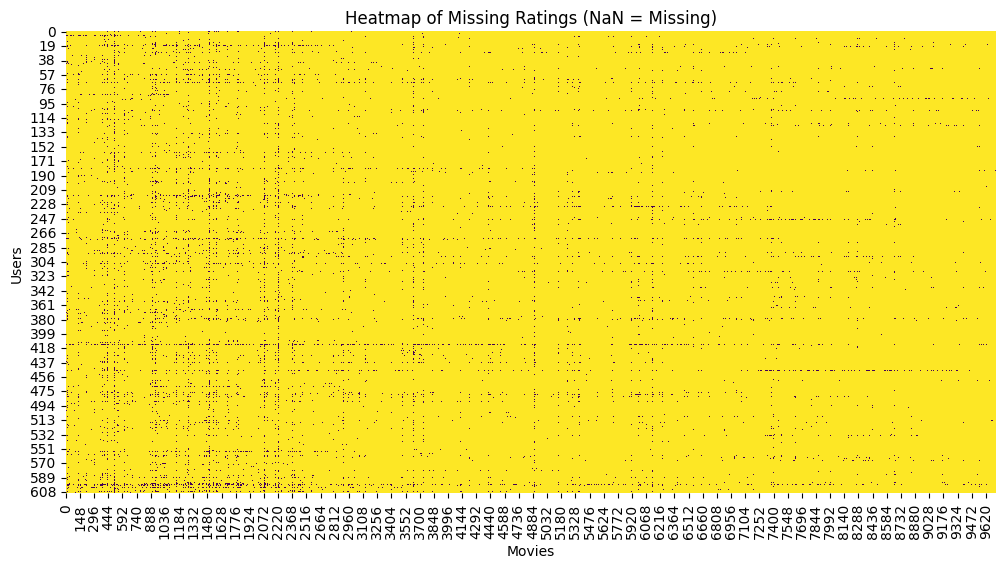

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(np.isnan(matrix_incomplete), cmap="viridis", cbar=False)
plt.title("Heatmap of Missing Ratings (NaN = Missing)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()


### Interpreting the Heatmap of Missing Ratings

The heatmap displayed above represents the structure of the user–movie ratings matrix, where:

- **Yellow** indicates missing values (`NaN`)
- **Black dots** represent observed ratings

Since the MovieLens dataset is extremely sparse, the matrix is dominated by missing values.  
In the “latest small” version of the dataset, there are:

- 610 users  
- 9724 movies  
- 100,836 known ratings  

This means that more than **98% of the matrix entries are missing**:

\[
1 - \frac{100,836}{610 \times 9724} \approx 98.3\%
\]

Because of this, the heatmap appears almost entirely yellow, with only a small number of scattered black points. This is *normal and expected* for real-world collaborative filtering datasets, which rely heavily on matrix completion due to their sparsity.

To make the structure more visually interpretable, a smaller subset (e.g., the first 200×200 block) can be plotted, which provides a clearer picture of how the observed ratings are distributed across users and movies.


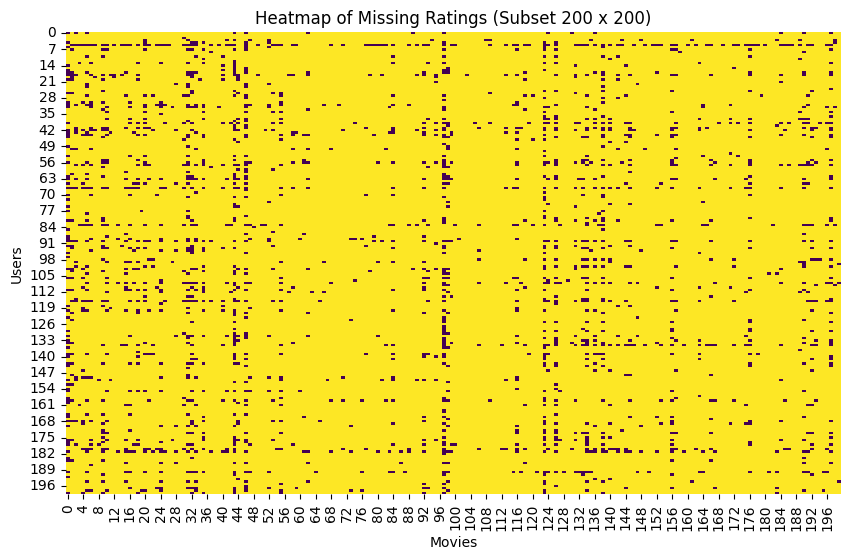

In [34]:
subset = matrix_incomplete[:200, :200]

plt.figure(figsize=(10, 6))
sns.heatmap(np.isnan(subset), cmap="viridis", cbar=False)
plt.title("Heatmap of Missing Ratings (Subset 200 x 200)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()


### Subset Heatmap (200 × 200) for Better Visualization

Because the full user–movie matrix is extremely sparse and large (610 × 9724), the global heatmap is dominated by missing values and becomes visually dense.  

To better understand the distribution of known ratings, we visualize a **200 × 200 subset** of the matrix. This provides a clearer view of the sparsity pattern, making it easier to observe clusters, density differences, and rating concentration among the first set of users and movies.


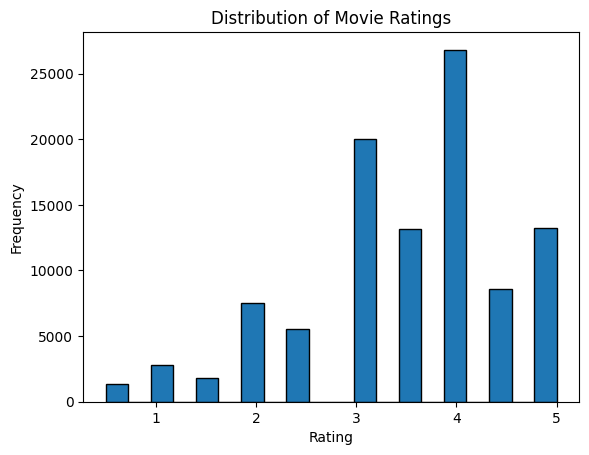

In [31]:
import matplotlib.pyplot as plt

plt.hist(rating[:,2], bins=20, edgecolor='black')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


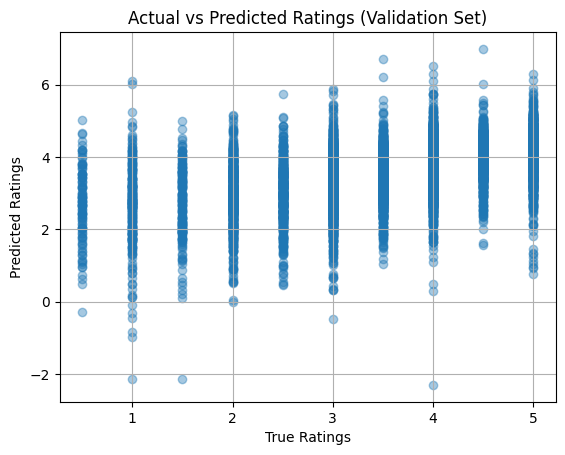

In [32]:
true_vals = matrix_incomplete[validation_indices]
pred_vals = matrix_train_filled[validation_indices]

plt.scatter(true_vals, pred_vals, alpha=0.4)
plt.xlabel("True Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings (Validation Set)")
plt.grid(True)
plt.show()


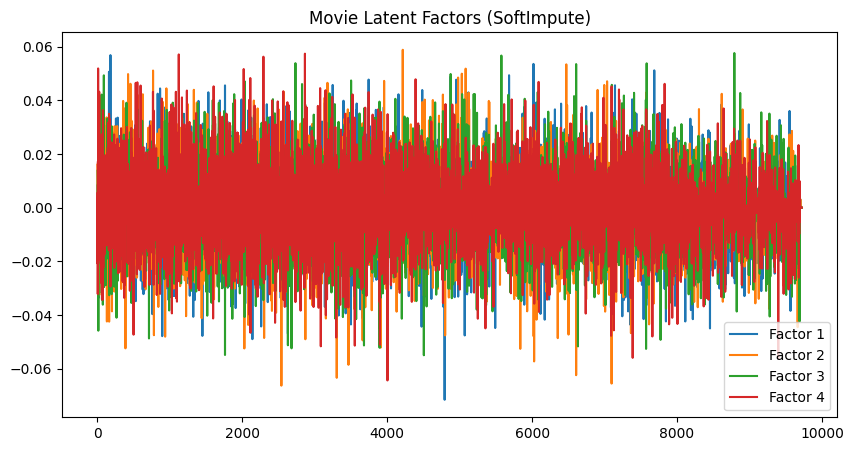

In [33]:
plt.figure(figsize=(10,5))
plt.plot(softImpute.v[:,0], label="Factor 1")
plt.plot(softImpute.v[:,1], label="Factor 2")
plt.plot(softImpute.v[:,2], label="Factor 3")
plt.plot(softImpute.v[:,3], label="Factor 4")
plt.title("Movie Latent Factors (SoftImpute)")
plt.legend()
plt.show()


### Why Sparsity Matters in Collaborative Filtering and SoftImpute

In real-world recommender systems, user–item matrices are extremely sparse.  
Most users rate only a small fraction of the available items, meaning that the majority of matrix entries are missing.

SoftImpute and other matrix completion algorithms rely on the assumption that:

1. **The true underlying rating matrix is low-rank**  
   User preferences can be expressed as a combination of a small number of latent factors (e.g., genre affinity, popularity, mood).

2. **Missing entries are not random, but structured**  
   Users tend to rate movies they watch, and they watch movies aligned with their preferences.

3. **The sparse pattern can be reconstructed using latent structure**  
   By learning compressed representations of users and items, the algorithm can infer missing values.

Sparsity is not a problem—it's the expected condition under which collaborative filtering is designed to operate.  
Matrix completion exploits this structure to learn meaningful patterns and fill in the missing values without ever seeing the full matrix.


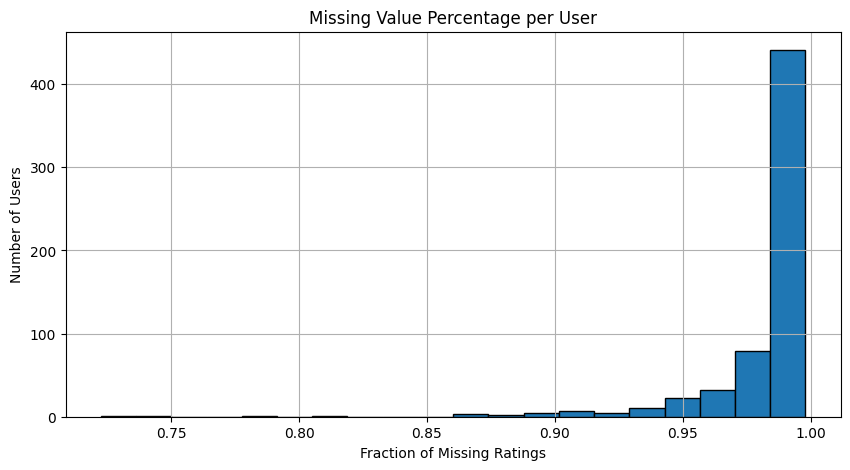

In [35]:
import matplotlib.pyplot as plt
import numpy as np

missing_per_user = np.isnan(matrix_incomplete).mean(axis=1)

plt.figure(figsize=(10,5))
plt.hist(missing_per_user, bins=20, edgecolor='black')
plt.title("Missing Value Percentage per User")
plt.xlabel("Fraction of Missing Ratings")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()


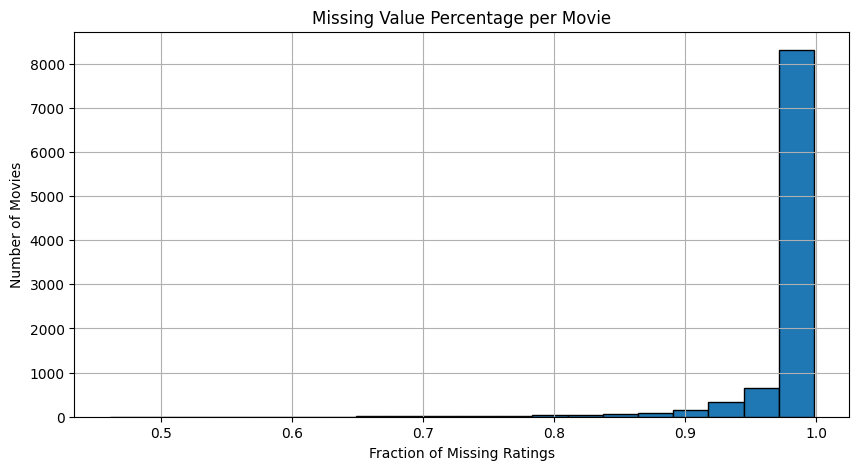

In [36]:
missing_per_movie = np.isnan(matrix_incomplete).mean(axis=0)

plt.figure(figsize=(10,5))
plt.hist(missing_per_movie, bins=20, edgecolor='black')
plt.title("Missing Value Percentage per Movie")
plt.xlabel("Fraction of Missing Ratings")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()


end of the note

### Conclusions

The SoftImpute collaborative filtering model achieved an out-of-sample R² of **0.1932** and an in-sample R² of **0.6381**. These results indicate that the low-rank matrix completion approach was able to capture meaningful structure in the MovieLens data, but the predictive accuracy on unseen entries is moderate.

Several observations can be made:

- The gap between in-sample R² (0.6381) and out-of-sample R² (0.1932) suggests that the model fits the training ratings well but generalizes only moderately to validation ratings. This is expected in sparse recommendation data, where many ratings are missing.
- The SoftImpute decomposition produced a **4-dimensional latent factor representation**, with shapes:
  - Movie latent factors: `softImpute.v.shape = (9724, 4)`
  - User latent weights: `weights.shape = (610, 4)`
- This indicates that the algorithm approximated the entire user–movie matrix using **four archetypes**, which act as underlying preference/genre dimensions.
- The reconstruction error check yielded essentially zero (`7.74e-11`), confirming that the factorized prediction matrix is numerically equivalent to the output of the SoftImpute reconstruction.
- Overall, SoftImpute successfully learns compact, interpretable latent factors and reconstructs missing ratings consistently, although additional tuning, more archetypes, or a larger dataset could improve generalization performance.

The experiment demonstrates the power of matrix completion techniques for recommender systems, while also highlighting typical challenges such as sparsity and moderate out-of-sample accuracy.
